# Projeto Wine Scrapper

> Um sistema para extração de dados e análise em sites de comércio e avaliação de vinhos

***


## Parte 1 - Web scrapper do site da Wine.com.br

### 1.1. Testes com páginas individuais

In [1]:
import requests
page = requests.get("https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p1.html")

from bs4 import BeautifulSoup as bs

soup = bs(page.content, 'html.parser')


product = soup.find('article', class_='ProductDisplay')

ProductName = product.find('div', class_='ProductDisplay-name')
product_name_a = ProductName.find('a')

print(product_name_a['title'])
print("https://wine.com.br" + product_name_a['href'])

country = product.find(class_="Country")
print(country.span.text)

wine_type = product.find(class_="ProductDisplay-type")
print(wine_type.span.text)

wine_description = product.find(class_="ProductDisplay-descriptionText")
print(wine_description.text)
      
# print(product_name_a.prettify())

Pérez Cruz Limited Edition D.O. Valle del Maipo Cabernet Franc 2016
https://wine.com.br/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html
Chile
tinto
Frutado, taninos presentes, médio corpo, fresco, amadeirado, especiarias


In [2]:
# Buscando Notas e numero de avaliações
import re

wine_rating = product.find('div',class_='Rating')
wine_evaluation_tag = wine_rating.find('evaluation-tag')
if (wine_evaluation_tag):
    wine_evaluation = re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group()
    wine_rating_count = re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group()
else:
    wine_evaluation = None
    wine_rating_count = 0

print(str(wine_rating))
print(wine_evaluation)
print(wine_rating_count)

<div class="Rating">
<div class="Rating-stars">
<div class="vue-evaluation-tag">
<evaluation-tag :evaluation="4.0"></evaluation-tag>
</div>
</div>
<a class="Rating-count" href="/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html#Comments">(7)</a>
</div>
4.0
7


In [3]:
# Buscando Preço

price_box = product.find(class_="ProductDisplay-priceBox")

lowest_price = price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text
full_price = price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text
print(lowest_price)
print(full_price)

discount = 1-float(lowest_price)/float(full_price)
print(discount)

145.76
180.90
0.1942509673852958


In [4]:
# Buscando Número de Páginas

pages_list = soup.find('div', class_='Pagination').ul.find_all('li')
int(pages_list[len(pages_list)-1].a.text)

47

In [5]:
# Juntando tudo para processar a lista de uma só página

wine_list = soup.find('div', class_='ProductList-content').ul.find_all('li')

for wine_item in wine_list:
    wine = wine_item.find('article', class_='ProductDisplay')

    wine_name = wine.find('div', class_='ProductDisplay-name').a['title']
    wine_link = "https://wine.com.br" + wine.find('div', class_='ProductDisplay-name').a['href']
    wine_country = wine.find(class_="Country").span.text
    wine_type = wine.find(class_="ProductDisplay-type").span.text
    wine_description = wine.find(class_="ProductDisplay-descriptionText").text
    
    wine_rating = wine.find('div',class_='Rating')
    wine_evaluation_tag = wine_rating.find('evaluation-tag')
    if (wine_evaluation_tag):
        wine_evaluation = re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group()
        wine_rating_count = re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group()
    else:
        wine_evaluation = None
        wine_rating_count = 0
    
    price_box = wine.find(class_="ProductDisplay-priceBox")

    lowest_price = price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text
    full_price = price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text
    discount = 1-float(lowest_price)/float(full_price)
    
    
    print(wine_name,";", wine_evaluation, ";", wine_rating_count, ";", wine_country, ";", wine_type, ";", lowest_price, ";", full_price, ";", discount,";", wine_description, ";", wine_link)

Pérez Cruz Limited Edition D.O. Valle del Maipo Cabernet Franc 2016 ; 4.0 ; 7 ; Chile ; tinto ; 145.76 ; 180.90 ; 0.1942509673852958 ; Frutado, taninos presentes, médio corpo, fresco, amadeirado, especiarias ; https://wine.com.br/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html
Finca La Chamiza Martín Alsina Malbec 2014 ; None ; 0 ; Argentina ; tinto ; 292.82 ; 495.90 ; 0.4095180479935471 ; Frutado, amadeirado, corpo de médio para encorpado, taninos presentes, acidez agradável ; https://wine.com.br/vinhos/finca-la-chamiza-martin-alsina-malbec-2014/prod20028.html
Domaine L'Ostal Cazes Grand Vin 2015 ; None ; 0 ; França ; tinto ; 258.71 ; 335.90 ; 0.22980053587377192 ; Encorpado, boa acidez, taninos macios ; https://wine.com.br/vinhos/domaine-l-ostal-cazes-grand-vin-2015/prod20143.html
Echo de Lynch-Bages A.O.C. Pauillac 2014 ; None ; 0 ; França ; tinto ; 721.06 ; 1056.90 ; 0.3177594852871607 ; Exuberante, encorpado, taninos presentes, boa acidez, 

In [22]:
import requests
from lxml.html import fromstring
from itertools import cycle
import traceback
import timeit

def get_proxies():
    url = 'https://free-proxy-list.net/'
    start = timeit.timeit()
    response = requests.get(url)
    end = timeit.timeit()
    print(end - start)
    parser = fromstring(response.text)
    #print (response.text)
    proxies = set()
    for i in parser.xpath('//tbody/tr')[:20]:
        #print(i.xpath('.//td[7][contains(text(),"yes")]'))
        if i.xpath('.//td[7][contains(text(),"yes")]'):
            proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
            proxies.add(proxy)
    return proxies

proxies = get_proxies()
print(proxies)
proxy_pool = cycle(proxies)

url = 'https://httpbin.org/ip'
for i in range(1,11):
    #Get a proxy from the pool
    proxy = next(proxy_pool)
    print("Request #%d"%i)
    try:
        start = timeit.timeit()
        response = requests.get(url,proxies={"http": proxy, "https": proxy})
        end = timeit.timeit()
        print (end - start)
        print(response.json())
    except:
        #Most free proxies will often get connection errors. You will have retry the entire request using another proxy to work. 
        #We will just skip retries as its beyond the scope of this tutorial and we are only downloading a single url 
        print("Skipping. Connnection error")

-0.0018271599992658594
{'103.83.116.210:55443', '109.239.243.211:23500', '123.195.152.139:32287', '194.8.146.167:50510', '27.255.13.134:49328'}
Request #1
-0.0012395980002111173
{'origin': '103.15.240.89'}
Request #2
Skipping. Connnection error
Request #3
Skipping. Connnection error
Request #4
Skipping. Connnection error
Request #5
Skipping. Connnection error
Request #6
Skipping. Connnection error
Request #7
0.0003484030003164662
{'origin': '109.239.243.211'}
Request #8
Skipping. Connnection error
Request #9
-0.0026197279994448763
{'origin': '194.8.146.167'}
Request #10
Skipping. Connnection error


### 1.2. Sistema Winescrapper

In [6]:
# Webscrapper do Site da Wine
# Cabeçalhos e Imports

from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import re
import time

URL_RAIZ="https://www.wine.com.br"
URL_BASE = URL_RAIZ+"/vinhos/tinto/cVINHOS-atTIPO_TINTO-p{0}.html"


HEADERS = {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 '
                   '(KHTML, like Gecko) Chrome/78.0.3904.87 Safari/537.36'),
    'Connection':'close'
}



In [7]:
# Funções

def get_num_pages(soup):
    
    pages_list = soup.find('div', class_='Pagination').ul.find_all('li')
    num_pages = int(pages_list[len(pages_list)-1].a.text) + 1
    
    return num_pages

def scrape_soup(soup):
    
    list_name=[]
    list_link, list_country, list_type, list_description= [], [], [], []
    list_evaluation, list_rating_count= [], []
    list_lowest_price, list_full_price, list_discount= [], [], []
    
    wine_list = soup.find('div', class_='ProductList-content').ul.find_all('li')

    for wine_item in wine_list:
        
        try:
            wine = wine_item.find('article', class_='ProductDisplay')

            wine_name = wine.find('div', class_='ProductDisplay-name').a['title']
            wine_link = "wine.com.br" + wine.find('div', class_='ProductDisplay-name').a['href']
            wine_country = wine.find(class_="Country").span.text
            wine_type = wine.find(class_="ProductDisplay-type").span.text
            wine_description = wine.find(class_="ProductDisplay-descriptionText").text
        
            wine_rating = wine.find('div',class_='Rating')
            wine_evaluation_tag = wine_rating.find('evaluation-tag')
            if (wine_evaluation_tag):
                wine_evaluation = float(re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group())
                wine_rating_count = float(re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group())
            else:
                wine_evaluation = 0
                wine_rating_count = 0
    
        
            price_box = wine.find(class_="ProductDisplay-priceBox")

            lowest_price = float(price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text)
            full_price = float(price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text)
            discount = 1-float(lowest_price)/float(full_price)
        except:
            if wine_name:
                print('skip incomplete item:', wine_name)
                continue
            else:
                print("skip incomplete item: no name")
                continue
        
        list_name.append(wine_name)
        list_link.append(wine_link)
        list_country.append(wine_country)
        list_type.append(wine_type)
        list_description.append(wine_description)
        
        list_evaluation.append(wine_evaluation)
        list_rating_count.append(wine_rating_count)

        list_lowest_price.append(lowest_price)
        list_full_price.append(full_price)
        list_discount.append(discount)
        
        ###print(wine_name,";", wine_evaluation, ";", wine_rating_count, ";", wine_country, ";", wine_type, ";", lowest_price, ";", full_price, ";", discount,";", wine_link)
    
    df = pd.DataFrame({
        'wine_name': list_name,
        'link': list_link,
        'country': list_country,
        'type': list_type,
        'description': list_description,
        'evaluation': list_evaluation,
        'rating_count': list_rating_count,
        'lowest_price': list_lowest_price,
        'full_price': list_full_price,
        'discount': list_discount
    })
    
    return df
        
    

def get_soup(page_url, retry_count=0):
    
    session= requests.Session()
    session.trust_env = False
    
    print("Iniciando session_get")
    
    try:
        response = session.get(page_url, headers=HEADERS)
        print("\nScraping page:",page_url," = ", response)
        soup = bs(response.content, 'html.parser')
        return soup
    except:
        print("Get falhou")
        retry_count += 1
        if retry_count <= 3:
            print("retry get")
            session = requests.Session()
            get_soup(page_url, retry_count)
        else:
            raise
    
    


    


In [9]:
# Módulo Principal - Processamento do Site

pages_to_scrape = 4

current_page = 1

wine_df = pd.DataFrame(columns=['wine_name','link','country','type','description','evaluation','rating_count','lowest_price','full_price','discount'])

while (current_page != pages_to_scrape):
    
    print("Iniciando get_soup pagina", current_page)
    
    wine_soup = get_soup(URL_BASE.format(current_page))
    
    if current_page == 1:
        pages_to_scrape = get_num_pages(wine_soup)
    
    new_df = scrape_soup(wine_soup)
    wine_df= wine_df.append(new_df, ignore_index=True)
    
    ###print(current_page)
    
    time.sleep(10)
    current_page += 1
    
print("Scrape finished.")
wine_df



Iniciando get_soup pagina 1
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p1.html  =  <Response [200]>
Iniciando get_soup pagina 2
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p2.html  =  <Response [200]>
Iniciando get_soup pagina 3
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p3.html  =  <Response [200]>
Iniciando get_soup pagina 4
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p4.html  =  <Response [200]>
Iniciando get_soup pagina 5
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p5.html  =  <Response [200]>
Iniciando get_soup pagina 6
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p6.html  =  <Response [200]>
Iniciando get_soup pagina 7
Iniciando session_get

Scraping page: https://www.wine

Iniciando get_soup pagina 41
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p41.html  =  <Response [200]>
skip incomplete item: WineBox Descomplicados
Iniciando get_soup pagina 42
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p42.html  =  <Response [200]>
skip incomplete item: WineBox Sofisticados
Iniciando get_soup pagina 43
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p43.html  =  <Response [200]>
skip incomplete item: WineBox Mãe comediante
skip incomplete item: WineBox Viñedo De Los Vientos Tannat
skip incomplete item: WineBox Diversos
Iniciando get_soup pagina 44
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p44.html  =  <Response [200]>
skip incomplete item: WineBox Três Continentes
skip incomplete item: WineBox Queridinhos
skip incomplete item: WineBox Adega Caprichada
skip incomple

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
0,Pérez Cruz Limited Edition D.O. Valle del Maip...,wine.com.br/vinhos/perez-cruz-limited-edition-...,Chile,tinto,"Frutado, taninos presentes, médio corpo, fresc...",4.0,7.0,145.76,180.90,0.194251
1,Finca La Chamiza Martín Alsina Malbec 2014,wine.com.br/vinhos/finca-la-chamiza-martin-als...,Argentina,tinto,"Frutado, amadeirado, corpo de médio para encor...",0.0,0.0,292.82,495.90,0.409518
2,Domaine L'Ostal Cazes Grand Vin 2015,wine.com.br/vinhos/domaine-l-ostal-cazes-grand...,França,tinto,"Encorpado, boa acidez, taninos macios",0.0,0.0,258.71,335.90,0.229801
3,Maycas del Limarí Reserva Especial Pinot Noir ...,wine.com.br/vinhos/maycas-del-limari-reserva-e...,Chile,tinto,"Bom corpo, acidez presente, taninos sedosos, f...",4.5,23.0,166.94,206.90,0.193137
4,Pauillac De Lynch-Bages 2015,wine.com.br/vinhos/pauillac-de-lynch-bages-201...,França,tinto,"Médio corpo, boa acidez, taninos presentes, fi...",3.0,1.0,364.59,630.90,0.422111
5,Château Puy-Blanquet A.O.C. Saint-Émilion Gran...,wine.com.br/vinhos/chateau-puy-blanquet-a-o-c-...,França,tinto,"Elegante, acidez agradável, bom corpo, taninos...",3.5,2.0,359.88,445.90,0.192913
6,Jean-Pierre Moueix A.O.C. Pomerol 2015,wine.com.br/vinhos/jean-pierre-moueix-a-o-c-po...,França,tinto,"Médio corpo, taninos macios, acidez agradável,...",0.0,0.0,339.88,414.90,0.180815
7,Echo de Lynch-Bages A.O.C. Pauillac 2014,wine.com.br/vinhos/echo-de-lynch-bages-a-o-c-p...,França,tinto,"Exuberante, encorpado, taninos presentes, boa ...",0.0,0.0,721.06,1056.90,0.317759
8,Château La Fleur-Pétrus A.O.C. Pomerol 2006,wine.com.br/vinhos/chateau-la-fleur-petrus-a-o...,França,tinto,"Aveludado, complexo, boa acidez, corpo de médi...",0.0,0.0,3614.00,6036.90,0.401348
9,Viña Vilano Roble Tempranillo 2016,wine.com.br/vinhos/vina-vilano-roble-tempranil...,Espanha,tinto,"Encorpado, taninos presentes, boa acidez, harm...",2.5,10.0,84.59,167.90,0.496188


In [10]:
# Análise do dados

wine_deals = wine_df.loc[(wine_df.rating_count>=36) & (wine_df.evaluation >= 4.2) & (wine_df.lowest_price < 66.20)]
wine_deals

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
182,Esteban Martín D.O.P. Cariñena Crianza 2015,wine.com.br/vinhos/esteban-martin-d-o-p-carine...,Espanha,tinto,"Médio corpo, acidez agradável, taninos firmes",4.5,67.0,55.18,73.90,0.253315
208,V9 Reserva Cabernet Sauvignon 2018,wine.com.br/vinhos/v9-reserva-cabernet-sauvign...,Chile,tinto,"Frutado, bom corpo, taninos presentes, fresco",4.5,64.0,50.47,62.90,0.197615
222,Esteban Martín Reserva D.O.P. Cariñena 2014,wine.com.br/vinhos/esteban-martin-reserva-d-o-...,Espanha,tinto,"Médio corpo, taninos macios, boa acidez, final...",4.5,96.0,65.76,88.90,0.260292
257,Root: 1 Reserva Heritage Red 2018,wine.com.br/vinhos/root-1-reserva-heritage-red...,Chile,tinto,"Médio corpo, taninos macios, acidez agradável",4.5,93.0,56.35,69.90,0.193848
303,Gérard Bertrand Narbo Martius Réserve Blend 2018,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Elegante, taninos aveludados e final agradável",4.5,414.0,54.67,54.67,0.000000
321,Gérard Bertrand Narbo Martius Cabernet Sauvign...,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Encorpado, taninos finos, final longo",4.5,429.0,64.90,64.90,0.000000
344,Toro Loco D.O.P. Utiel-Requena Tinto Superior ...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,tinto,"Frutado, corpo de leve para médio, taninos mac...",4.5,499.0,44.59,52.90,0.157089


In [11]:
wine_exotic = wine_df.loc[~wine_df.country.isin(['Chile','França','Espanha','Argentina','Itália','Portugal','Brasil','Estados Unidos','Uruguai'])]
wine_exotic.loc[wine_exotic.country == 'China']

#wine_exotic.iloc[2].link

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
147,Chateau Moser XV Cabernet Sauvignon 2017,wine.com.br/vinhos/chateau-moser-xv-cabernet-s...,China,tinto,"Saboroso, encorpado, boa acidez",3.5,23.0,46.94,85.9,0.453551
171,Changyu Reserve Noble Dragon Red 2016,wine.com.br/vinhos/changyu-reserve-noble-drago...,China,tinto,"Encorpado, frutado, taninos firmes.",3.5,81.0,55.18,76.9,0.282445


In [12]:
# Exemplo do uso de Describe
wine_df.lowest_price.describe()

count      364.000000
mean       489.398571
std       1546.066614
min         38.710000
25%         71.070000
50%        110.900000
75%        212.532500
max      14598.710000
Name: lowest_price, dtype: float64

In [13]:
# Mais um exemplo de Describe

wine_df.loc[wine_df.evaluation > 0].describe()

,evaluation,rating_count,lowest_price,full_price,discount
count,281.000000,281.000000,281.000000,281.000000,281.000000
mean,4.040925,45.491103,220.758754,313.892420,0.216269
std,0.613187,115.777160,755.146009,1197.310301,0.146544
min,1.000000,1.000000,38.710000,43.900000,0.000000
25%,4.000000,5.000000,66.940000,88.900000,0.106641
50%,4.000000,16.000000,94.000000,122.900000,0.213691
75%,4.500000,42.000000,151.650000,194.900000,0.321269
max,5.000000,1365.000000,9303.410000,14794.900000,0.879230


In [14]:
#Exemplo de funções de sumário

print(wine_df.country.describe())
print(wine_df.rating_count.mean())
print(wine_df.country.unique())

count        364
unique        15
top       França
freq          81
Name: country, dtype: object
35.11813186813187
['Chile' 'Argentina' 'França' 'Espanha' 'Estados Unidos' 'Itália' 'Brasil'
 'Uruguai' 'Áustria' 'Portugal' 'Líbano' 'África do Sul' 'China'
 'Austrália' 'Alemanha']


In [15]:
# Exemplo de groupby
wine_df.groupby('country').lowest_price.min()

country
Alemanha          119.90
Argentina          44.59
Austrália         120.90
Brasil             83.90
Chile              39.88
China              46.94
Espanha            39.88
Estados Unidos     52.82
França             39.88
Itália             46.94
Líbano            125.76
Portugal           43.41
Uruguai            38.71
África do Sul      45.76
Áustria           126.94
Name: lowest_price, dtype: float64

In [16]:
# Exemplo de min
wine_deals.groupby('country').lowest_price.min()

country
Chile      50.47
Espanha    44.59
França     54.67
Name: lowest_price, dtype: float64

In [17]:
# Exemplo de Apply
wine_df.groupby(['country','type']).apply(lambda df: df.loc[df.rating_count.idxmax()])

,,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
country,type,,,,,,,,,,
Alemanha,tinto,Ernst Loosen Winemakers Select Pfalz Edition P...,wine.com.br/vinhos/ernst-loosen-winemakers-sel...,Alemanha,tinto,"Leve, acidez presente, taninos sedosos",4.0,20.0,119.90,119.90,0.000000
Argentina,tinto,Clos de Los Siete By Michel Rolland 2016,wine.com.br/vinhos/clos-de-los-siete-by-michel...,Argentina,tinto,"Encorpado, taninos presentes, boa acidez, boa ...",4.5,332.0,130.47,179.90,0.274764
Austrália,tinto,Oxford Landing Shiraz 2017,wine.com.br/vinhos/oxford-landing-shiraz-2017/...,Austrália,tinto,"Corpo de leve para médio, taninos macios, boa ...",3.0,6.0,120.90,120.90,0.000000
Brasil,tinto,Salton Desejo 2015,wine.com.br/vinhos/salton-desejo-2015/prod2220...,Brasil,tinto,"Corpo de médio para encorpado, taninos present...",4.5,9.0,114.00,139.90,0.185132
Chile,tinto,Undurraga Talagante Reserva Pinot Noir 2018,wine.com.br/vinhos/undurraga-talagante-reserva...,Chile,tinto,"Fresco, jovem, corpo médio e com bela acidez",4.0,497.0,58.90,58.90,0.000000
China,tinto,Changyu Reserve Noble Dragon Red 2016,wine.com.br/vinhos/changyu-reserve-noble-drago...,China,tinto,"Encorpado, frutado, taninos firmes.",3.5,81.0,55.18,76.90,0.282445
Espanha,tinto,Viña Cosos D.O. Campo de Borja Garnacha Tempra...,wine.com.br/vinhos/vina-cosos-d-o-campo-de-bor...,Espanha,tinto,"Macio, taninos sedosos, final agradável",4.0,503.0,67.90,67.90,0.000000
Estados Unidos,tinto,Bear Flag Red Blend 2018,wine.com.br/vinhos/bear-flag-red-blend-2018/pr...,Estados Unidos,tinto,"Encorpado, macio, saboroso e com final persist...",4.0,1365.0,62.24,76.90,0.190637
França,tinto,Café du Midi IGP Pays dOc Cabernet Sauvignon 2019,wine.com.br/vinhos/cafe-du-midi-igp-pays-doc-c...,França,tinto,"Bom corpo, boa acidez e final agradável",4.0,491.0,58.75,58.75,0.000000


In [18]:
# Exemplo de sort

sorted_wines = wine_deals.sort_values(by=['lowest_price','evaluation'])
sorted_wines

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
344,Toro Loco D.O.P. Utiel-Requena Tinto Superior ...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,tinto,"Frutado, corpo de leve para médio, taninos mac...",4.5,499.0,44.59,52.90,0.157089
208,V9 Reserva Cabernet Sauvignon 2018,wine.com.br/vinhos/v9-reserva-cabernet-sauvign...,Chile,tinto,"Frutado, bom corpo, taninos presentes, fresco",4.5,64.0,50.47,62.90,0.197615
303,Gérard Bertrand Narbo Martius Réserve Blend 2018,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Elegante, taninos aveludados e final agradável",4.5,414.0,54.67,54.67,0.000000
182,Esteban Martín D.O.P. Cariñena Crianza 2015,wine.com.br/vinhos/esteban-martin-d-o-p-carine...,Espanha,tinto,"Médio corpo, acidez agradável, taninos firmes",4.5,67.0,55.18,73.90,0.253315
257,Root: 1 Reserva Heritage Red 2018,wine.com.br/vinhos/root-1-reserva-heritage-red...,Chile,tinto,"Médio corpo, taninos macios, acidez agradável",4.5,93.0,56.35,69.90,0.193848
321,Gérard Bertrand Narbo Martius Cabernet Sauvign...,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Encorpado, taninos finos, final longo",4.5,429.0,64.90,64.90,0.000000
222,Esteban Martín Reserva D.O.P. Cariñena 2014,wine.com.br/vinhos/esteban-martin-reserva-d-o-...,Espanha,tinto,"Médio corpo, taninos macios, boa acidez, final...",4.5,96.0,65.76,88.90,0.260292


In [19]:
# Exemplo de iterator em DataFrame

for index, row in sorted_wines.iterrows():
    print(row.wine_name, "\t", row.link)



Toro Loco D.O.P. Utiel-Requena Tinto Superior 2018 	 wine.com.br/vinhos/toro-loco-d-o-p-utiel-requena-tinto-superior-2018/prod23299.html
V9 Reserva Cabernet Sauvignon 2018 	 wine.com.br/vinhos/v9-reserva-cabernet-sauvignon-2018/prod22182.html
Gérard Bertrand Narbo Martius Réserve Blend 2018 	 wine.com.br/vinhos/gerard-bertrand-narbo-martius-reserve-blend-2018/prod23409.html
Esteban Martín D.O.P. Cariñena Crianza 2015 	 wine.com.br/vinhos/esteban-martin-d-o-p-carinena-crianza-2015/prod20149.html
Root: 1 Reserva Heritage Red 2018 	 wine.com.br/vinhos/root-1-reserva-heritage-red-2018/prod22767.html
Gérard Bertrand Narbo Martius Cabernet Sauvignon 2018 	 wine.com.br/vinhos/gerard-bertrand-narbo-martius-cabernet-sauvignon-2018/prod23408.html
Esteban Martín Reserva D.O.P. Cariñena 2014 	 wine.com.br/vinhos/esteban-martin-reserva-d-o-p-carinena-2014/prod20150.html


### 1.3. Análise Descritiva - Wine


In [20]:
# Gráficos

import matplotlib.pyplot as plt

#wine_df.boxplot(column=wine_df.groupby('country'))
wine_df.groupby('country')['lowest_price'].describe()


,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Alemanha,1.0,119.900000,NaN,119.90,119.9000,119.900,119.90,119.90
Argentina,34.0,131.548529,113.680875,44.59,64.2975,82.240,145.68,565.76
Austrália,2.0,120.900000,0.000000,120.90,120.9000,120.900,120.90,120.90
Brasil,9.0,129.968889,54.737937,83.90,111.6500,124.590,128.90,268.12
Chile,66.0,129.071970,134.080497,39.88,62.2400,90.470,145.76,941.06
China,2.0,51.060000,5.826560,46.94,49.0000,51.060,53.12,55.18
Espanha,58.0,92.751379,49.987300,39.88,61.6475,78.710,106.90,304.59
Estados Unidos,35.0,591.929714,1562.824231,52.82,118.3400,163.410,217.53,8938.71
França,81.0,1508.653086,2882.718151,39.88,99.8800,257.530,721.06,14598.71


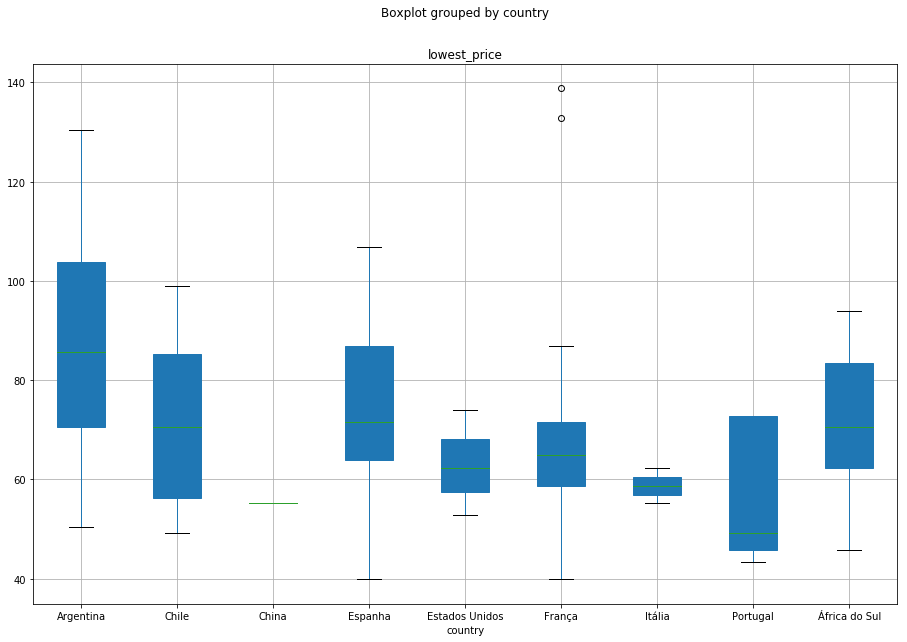

In [21]:
wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 200.0) & (wine_df.rating_count > 34.0)].boxplot(by='country',column=['lowest_price'], figsize=(15,10), patch_artist=True)

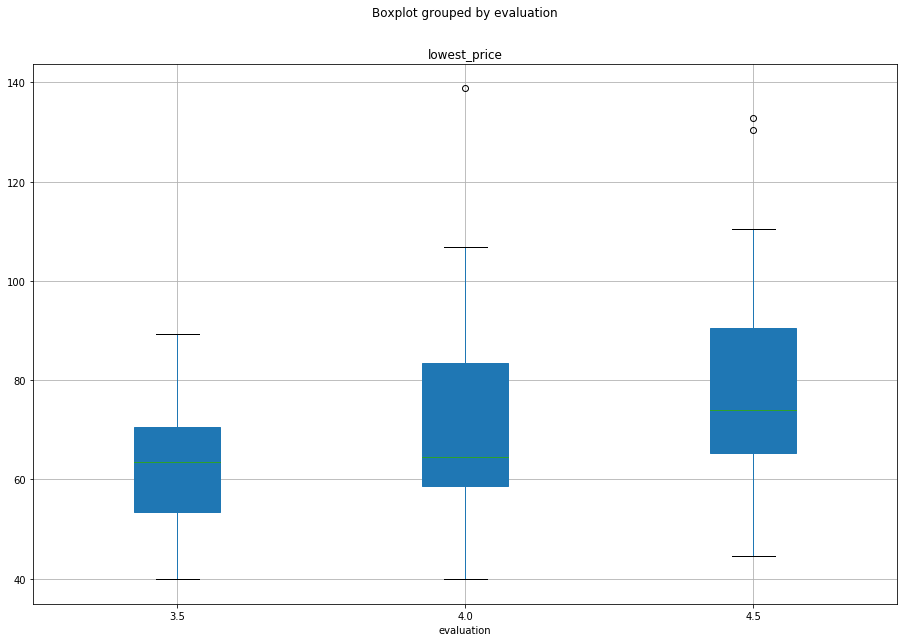

In [22]:
wine_plot = wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 1000.0) & (wine_df.rating_count > 34.0)]
wine_plot.boxplot(by='evaluation',column=['lowest_price'], figsize=(15,10), patch_artist=True)

In [23]:
wine_df.evaluation.corr(wine_df.lowest_price)

-0.2922655545366668

## Parte 2 - Busca no Vivino

### 2.1. Testes Individuais

#### URL Encoding para buscar no Vivino


In [32]:
import urllib.parse

wine_deals = wine_df.loc[(wine_df.rating_count>=36) & (wine_df.evaluation >= 4.2)]
sorted_wines = wine_deals.sort_values(by=['lowest_price','evaluation'])

#row = next(sorted_wines.iterrows())[1]
#Pegando o segundo da lista
row = sorted_wines.iloc[0]

query_url = urllib.parse.quote(row.wine_name)
row.wine_name

#for index, row in sorted_wines.iterrows():
#    query_url = urllib.parse.quote(row.wine_name)
#    print(query_url.replace("%20","+"), "\t", 'https://'+row.link)

'Toro Loco D.O.P. Utiel-Requena Tinto Superior 2018'

In [27]:
new_url = 'https://www.vivino.com/search/wines?q='+query_url.replace("%20","+")
new_url

'https://www.vivino.com/search/wines?q=Toro+Loco+D.O.P.+Utiel-Requena+Tinto+Superior+2018'

In [28]:
row.link

'wine.com.br/vinhos/toro-loco-d-o-p-utiel-requena-tinto-superior-2018/prod23299.html'

#### Busca no Vivino


In [ ]:
vivino_soup = get_soup(new_url)

#print(vivino_soup.body.prettify())

In [ ]:
vivino_search_item = vivino_soup.find('div', class_="wine-card__content")

vivino_name = vivino_search_item.find('span', class_="wine-card__name").text.replace("\n","")
print(vivino_name)

vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
try:
    vivino_average_score = float(vivino_average_score_txt.replace(",","."))
except:
    vivino_average_score = vivino_average_score_txt
print(vivino_average_score)

try:
    vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
    vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
except:
    vivino_rating = None
print(vivino_rating)

vivino_price = vivino_search_item.find('div', class_="wine-price")
vivino_price

#### Tentando com Selenium

In [ ]:
from selenium import webdriver

browser = webdriver.Chrome('/Users/giuliano/Documents/dev-python/scrapper/bin/chromedriver')
browser.get(new_url)

vivino_soup_byselenium = bs(browser.page_source,'html.parser')

vivino_search_item = vivino_soup_byselenium.find('div', class_="wine-card__content")


In [ ]:
vivino_name_card = vivino_search_item.find('span', class_="wine-card__name")
vivino_name = vivino_name_card.text.replace("\n","")
print(vivino_name)

vivino_link = 'www.vivino.com'+vivino_name_card.a['href']
print(vivino_link)

vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
try:
    vivino_average_score = float(vivino_average_score_txt.replace(",","."))
except:
    vivino_average_score = vivino_average_score_txt
print(vivino_average_score)

try:
    vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
    vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
except:
    vivino_rating = None
print(vivino_rating)

try:
    vivino_price_txt = vivino_search_item.find('span', class_="wine-price-value").text
    vivino_price = float(vivino_price_txt.replace(",","."))
except:
    vivino_price = None
print(vivino_price)

In [ ]:
browser.close()

### 2.1. Prova de Conceito

> Busca vinhos do dataframe da wine no vivino, acha os dados e cria um novo dataframe.

In [53]:
from selenium import webdriver
from time import perf_counter

VIVINO_SEARCH_URL = 'https://www.vivino.com/search/wines?q='

browser = webdriver.Chrome('/Users/giuliano/Documents/dev-python/scrapper/bin/chromedriver')

reference_df = wine_df

lst_vivino_name, lst_vivino_link, lst_vivino_score, lst_vivino_rating, lst_vivino_price = [], [], [], [], []
lst_original_name = []

for index, row in reference_df.iterrows():
    
    query_url = urllib.parse.quote(row.wine_name)
    new_url = VIVINO_SEARCH_URL+query_url.replace("%20","+")
    
    print("Searching...", new_url)
    
    start_time = perf_counter()
    
    try:
        browser.get(new_url)
        vivino_soup_byselenium = bs(browser.page_source,'html.parser')
        vivino_search_item = vivino_soup_byselenium.find('div', class_="wine-card__content")
        vivino_name_card = vivino_search_item.find('span', class_="wine-card__name")
        vivino_name = vivino_name_card.text.replace("\n","")
        lst_original_name.append(row.wine_name)
        lst_vivino_name.append(vivino_name)

        vivino_link = 'www.vivino.com'+vivino_name_card.a['href']
        lst_vivino_link.append(vivino_link)

        vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
        try:
            vivino_average_score = float(vivino_average_score_txt.replace(",","."))
        except:
            vivino_average_score = None
        lst_vivino_score.append(vivino_average_score)

        try:
            vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
            vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
        except:
            vivino_rating = None
        lst_vivino_rating.append(vivino_rating)

        try:
            vivino_price_txt = vivino_search_item.find('span', class_="wine-price-value").text
            vivino_price = float(vivino_price_txt.replace(",","."))
        except:
            vivino_price = None
        lst_vivino_price.append(vivino_price)
    
        time.sleep(2)
    except:
        print("Next!")
    
    elapsed_time = perf_counter()-start_time
    print("tempo: ", elapsed_time)
        
    
browser.close()

df = pd.DataFrame({
        'wine_name' : lst_original_name,
        'vivino_name': lst_vivino_name,
        'vivino_link': lst_vivino_link,
        'vivino_score': lst_vivino_score,
        'vivino_rating': lst_vivino_rating,
        'vivino_price': lst_vivino_price,
    })

df
    
    

Searching... https://www.vivino.com/search/wines?q=P%C3%A9rez+Cruz+Limited+Edition+D.O.+Valle+del+Maipo+Cabernet+Franc+2016
tempo:  5.584343892000106
Searching... https://www.vivino.com/search/wines?q=Finca+La+Chamiza+Mart%C3%ADn+Alsina+Malbec+2014
tempo:  4.664927040999828
Searching... https://www.vivino.com/search/wines?q=Domaine+L%27Ostal+Cazes+Grand+Vin+2015
tempo:  3.4484413209993363
Searching... https://www.vivino.com/search/wines?q=Maycas+del+Limar%C3%AD+Reserva+Especial+Pinot+Noir+2017
tempo:  3.3687298069999088
Searching... https://www.vivino.com/search/wines?q=Pauillac+De+Lynch-Bages+2015
tempo:  3.10816535199956
Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+Puy-Blanquet+A.O.C.+Saint-%C3%89milion+Grand+Cru+2011
tempo:  3.576849781000419
Searching... https://www.vivino.com/search/wines?q=Jean-Pierre+Moueix+A.O.C.+Pomerol+2015
tempo:  3.5263786480009003
Searching... https://www.vivino.com/search/wines?q=Echo+de+Lynch-Bages+A.O.C.+Pauillac+2014
tempo:  3.316070

tempo:  3.1102957849998347
Searching... https://www.vivino.com/search/wines?q=La+Chamiza+Reserve+Polo+Profesional+Cabernet+Sauvignon+2017
tempo:  3.200885557998845
Searching... https://www.vivino.com/search/wines?q=Edna+Valley+Central+Coast+Pinot+Noir+2017
tempo:  2.814350259999628
Searching... https://www.vivino.com/search/wines?q=Gallo+Family+Vineyards+Calif%C3%B3rnia+Pinot+Noir+2017
tempo:  3.1896936719986115
Searching... https://www.vivino.com/search/wines?q=Pavillon+Rouge+du+Ch%C3%A2teau+Margaux++2010
tempo:  3.084148730000379
Searching... https://www.vivino.com/search/wines?q=Dominus+Estate+Napa+Valley+2012
tempo:  3.2197388719996525
Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+Palmer+2005
tempo:  3.017277417000514
Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+Roylland+2012
tempo:  3.186184496998976
Searching... https://www.vivino.com/search/wines?q=Tintorera+D.O.P.+Alicante+Bouschet+Monastrell+2016
tempo:  3.448573743000452
Searching... https

tempo:  3.011788850000812
Searching... https://www.vivino.com/search/wines?q=Bon+Mas+D.O.Q.+Priorat+2017
tempo:  3.2181775869994453
Searching... https://www.vivino.com/search/wines?q=Famille+J-M+Cazes+A.O.C.+Saint-Est%C3%A8phe+2015
tempo:  3.5115634800004045
Searching... https://www.vivino.com/search/wines?q=Canepa+Finisimo+Gran+Reserva+Cabernet+Sauvignon+2018
tempo:  2.725536274998376
Searching... https://www.vivino.com/search/wines?q=Carpineto+D.O.C.G.+Brunello+di+Montalcino+2014
tempo:  3.6117423599989706
Searching... https://www.vivino.com/search/wines?q=Alvarez+de+Toledo+Roble+D.O.+Bierzo+Menc%C3%ADa+2013
tempo:  3.611998027001391
Searching... https://www.vivino.com/search/wines?q=P%C3%A1jaro+de+Buen+Ag%C3%BCero+D.O.P.+Cari%C3%B1ena+G+2018
tempo:  3.04030787100055
Searching... https://www.vivino.com/search/wines?q=Mixtus+Syrah+Malbec+2018
tempo:  3.161066243001187
Searching... https://www.vivino.com/search/wines?q=La+Mora+D.O.C.+Maremma+Toscana+Merlot+2015
tempo:  3.11183564299972

tempo:  3.9884734070001286
Searching... https://www.vivino.com/search/wines?q=Louis+M.+Martini+Napa+Valley+Cabernet+Sauvignon+2016
tempo:  3.34747026200057
Searching... https://www.vivino.com/search/wines?q=Fortant+de+France+Terroir+Littoral+Cabernet+Sauvignon+2018
tempo:  3.8412285760005034
Searching... https://www.vivino.com/search/wines?q=W+Explorer+Series+Barahonda+D.O.+Yecla+2014
tempo:  4.269029565000892
Searching... https://www.vivino.com/search/wines?q=V9+Reserva+Cabernet+Sauvignon+2018
tempo:  3.1513730759997998
Searching... https://www.vivino.com/search/wines?q=La+Chamiza+Reserve+Polo+Profesional+Malbec+2017
tempo:  2.7114210489999095
Searching... https://www.vivino.com/search/wines?q=Mosaiko+2015
tempo:  3.0026326539991715
Searching... https://www.vivino.com/search/wines?q=Apothic+Red+2017
tempo:  3.147012649998942
Searching... https://www.vivino.com/search/wines?q=Infame+Reserva+Carm%C3%A9n%C3%A8re+2018
tempo:  3.0801660560009623
Searching... https://www.vivino.com/search/w

tempo:  3.6015054149993375
Searching... https://www.vivino.com/search/wines?q=Finca+Constancia+Parcela+23+Single+Vineyard+Tempranillo+2016
tempo:  3.2973964770008024
Searching... https://www.vivino.com/search/wines?q=Louis+M.+Martini+Sonoma+County+Cabernet+Sauvignon+2015
tempo:  3.005191845999434
Searching... https://www.vivino.com/search/wines?q=P%C3%A9rez+Cruz+Reserva+D.O.+Valle+del+Maipo+Cabernet+Sauvignon+2016
tempo:  3.840949093000745
Searching... https://www.vivino.com/search/wines?q=Fortant+de+France+Terroir+d%27Altitude+Syrah+2017
tempo:  3.4566355209990434
Searching... https://www.vivino.com/search/wines?q=Terrazas+de+Los+Andes+Reserva+Cabernet+Sauvignon+2016
tempo:  3.7484341529998346
Searching... https://www.vivino.com/search/wines?q=Oxford+Landing+Cabernet+Shiraz+2016
tempo:  2.983118578000358
Searching... https://www.vivino.com/search/wines?q=Beaupont
tempo:  3.5108865100010007
Searching... https://www.vivino.com/search/wines?q=Petravia+I.G.T.+Puglia+Aglianico+2016
tempo: 

tempo:  2.820289383000272
Searching... https://www.vivino.com/search/wines?q=Dalera
tempo:  3.2577286069990805
Searching... https://www.vivino.com/search/wines?q=Finca+Traversa+Cabernet+Sauvignon+2019
tempo:  2.8287579080006253
Searching... https://www.vivino.com/search/wines?q=Carnivor+Cabernet+Sauvignon+2016
tempo:  3.089850907001164
Searching... https://www.vivino.com/search/wines?q=Toro+Loco+D.O.P.+Utiel-Requena+Tinto+Superior+2018
tempo:  2.982835488001001
Searching... https://www.vivino.com/search/wines?q=Undurraga+Talagante+Reserva+Pinot+Noir+2018
tempo:  2.7733409119991848
Searching... https://www.vivino.com/search/wines?q=Ch%C3%A2teau+de+Fayolle+Rouge+2016
tempo:  3.097385409000708
Searching... https://www.vivino.com/search/wines?q=P%C3%A9rez+Cruz+GSM+D.O.+Valle+del+Maipo+Andes+2016
tempo:  3.1266213939998124
Searching... https://www.vivino.com/search/wines?q=Pavillon+Saint+Pierre+R%C3%A9serve+2016
tempo:  3.222140356998352
Searching... https://www.vivino.com/search/wines?q=Ro

,wine_name,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
0,Pérez Cruz Limited Edition D.O. Valle del Maip...,Perez Cruz Cabernet Franc Limited Edition 2016,www.vivino.com/wines/144769511,4.0,881.0,129.5
1,Finca La Chamiza Martín Alsina Malbec 2014,La Chamiza Martin Alsina Malbec 2014,www.vivino.com/wines/11537877,4.2,97.0,168.0
2,Domaine L'Ostal Cazes Grand Vin 2015,L'Ostal Cazes Grand Vin Minervois La Livinière...,www.vivino.com/wines/120763131,3.9,219.0,NaN
3,Maycas del Limarí Reserva Especial Pinot Noir ...,Maycas del Limari Reserva Especial Pinot Noir ...,www.vivino.com/wines/152575001,3.7,222.0,NaN
4,Pauillac De Lynch-Bages 2015,Château Lynch-Bages Pauillac de Lynch-Bages 2015,www.vivino.com/wines/63019180,4.0,382.0,NaN
5,Château Puy-Blanquet A.O.C. Saint-Émilion Gran...,Château Puy-Blanquet Saint-Émilion Grand Cru 2011,www.vivino.com/wines/1226210,3.8,475.0,NaN
6,Jean-Pierre Moueix A.O.C. Pomerol 2015,Jean-Pierre Moueix Pomerol 2015,www.vivino.com/wines/30275265,3.8,341.0,NaN
7,Echo de Lynch-Bages A.O.C. Pauillac 2014,Château Lynch-Bages Echo de Lynch-Bages Pauill...,www.vivino.com/wines/4436388,4.0,502.0,NaN
8,Château La Fleur-Pétrus A.O.C. Pomerol 2006,Château La Fleur-Pétrus Pomerol 2006,www.vivino.com/wines/1150888,4.5,452.0,NaN
9,Viña Vilano Roble Tempranillo 2016,Nuestra Señora de la Cabeza Viña Roniel Roble ...,www.vivino.com/wines/155198643,NaN,NaN,NaN


In [55]:
result = pd.merge(reference_df, df, on='wine_name')
result.sort_values(by=['vivino_score','lowest_price'], ascending = False, na_position = 'last')

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
100,Opus One 2013,wine.com.br/vinhos/opus-one-2013/prod19463.html,Estados Unidos,tinto,"Complexo, exuberante, encorpado, boa acidez, t...",0.0,0.0,8938.71,10717.90,0.166002,Opus One Opus One 2013,www.vivino.com/wines/2794433,4.6,5357.0,NaN
58,Château Mouton Rothschild Premier Grand Cru Cl...,wine.com.br/vinhos/chateau-mouton-rothschild-p...,França,tinto,"Suculento, harmonioso, maduro, taninos aveluda...",5.0,1.0,9303.41,14794.90,0.371175,Château Mouton Rothschild Pauillac (Premier Gr...,www.vivino.com/wines/3085744,4.5,865.0,NaN
54,Château Margaux Premier Grand Cru Classé A.O.C...,wine.com.br/vinhos/chateau-margaux-premier-gra...,França,tinto,As frutas dominam o paladar e mesclam-se às no...,0.0,0.0,8381.06,13324.90,0.371023,Château Margaux Château Margaux (Premier Grand...,www.vivino.com/wines/1168755,4.5,664.0,NaN
31,Château de Beaucastel Hommage à Jacques Perrin...,wine.com.br/vinhos/chateau-de-beaucastel-homma...,França,tinto,"Denso, exuberante, estruturado, concentrado, b...",0.0,0.0,6739.88,10789.90,0.375353,Château de Beaucastel Hommage à Jacques Perrin...,www.vivino.com/wines/3896910,4.5,502.0,NaN
34,Château La Fleur-Pétrus 2014,wine.com.br/vinhos/chateau-la-fleur-petrus-201...,França,tinto,"Complexo, elegante, corpo de médio para encorp...",4.0,1.0,4044.59,6564.90,0.383907,Château La Fleur-Pétrus Pomerol 2014,www.vivino.com/wines/4237999,4.5,176.0,NaN
8,Château La Fleur-Pétrus A.O.C. Pomerol 2006,wine.com.br/vinhos/chateau-la-fleur-petrus-a-o...,França,tinto,"Aveludado, complexo, boa acidez, corpo de médi...",0.0,0.0,3614.00,6036.90,0.401348,Château La Fleur-Pétrus Pomerol 2006,www.vivino.com/wines/1150888,4.5,452.0,NaN
134,Almaviva EPU 2016,wine.com.br/vinhos/almaviva-epu-2016/prod23311...,Chile,tinto,"Corpo de médio para encorpado, fresco, taninos...",3.0,2.0,522.24,705.90,0.260178,Almaviva EPU 2016,www.vivino.com/wines/92792459,4.5,441.0,NaN
71,Pavillon Rouge du Château Margaux 2010,wine.com.br/vinhos/pavillon-rouge-du-chateau-m...,França,tinto,"Potente, boa acidez, taninos presentes, elegan...",0.0,0.0,4091.65,6542.90,0.374643,Château Margaux Pavillon Rouge du Château Marg...,www.vivino.com/wines/1219282,4.4,429.0,NaN
56,Château Gazin 2009,wine.com.br/vinhos/chateau-gazin-2009/prod1289...,França,tinto,"Aveludado, equilibrado, fresco, taninos presentes",0.0,0.0,2361.06,3848.90,0.386562,Château Gazin Pomerol 2009,www.vivino.com/wines/1286336,4.4,476.0,NaN
87,Almaviva EPU 2015 375 ml,wine.com.br/vinhos/almaviva-epu-2015-375-ml/pr...,Chile,tinto,"Corpo de médio para encorpado, fresco, taninos...",3.5,3.0,266.94,388.90,0.313602,Almaviva EPU,www.vivino.com/wines/1474681,4.4,19983.0,NaN


In [56]:
result_clean = result.loc[(result.vivino_rating>=100) & (result.lowest_price <= 100.0)]
result_clean.sort_values(by=['vivino_score','lowest_price'], ascending = False, na_position = 'last')

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
177,Pérez Cruz Winemakers Selection 2017,wine.com.br/vinhos/perez-cruz-winemakers-selec...,Chile,tinto,"Médio corpo, taninos macios, acidez agradável,...",4.5,31.0,92.82,103.9,0.106641,Perez Cruz Winemaker's Selection 2017,www.vivino.com/wines/152443541,3.9,230.0,NaN
316,Pérez Cruz Single Vineyard La Higuera Block 2017,wine.com.br/vinhos/perez-cruz-single-vineyard-...,Chile,tinto,"Corpo de médio para encorpado, taninos present...",4.0,40.0,92.82,103.9,0.106641,Perez Cruz La Higuera Block Single Vineyard 2017,www.vivino.com/wines/156052147,3.9,349.0,NaN
263,Undurraga Sibaris Black Series Blend 2017,wine.com.br/vinhos/undurraga-sibaris-black-ser...,Chile,tinto,"Encorpado, taninos firmes e boa acidez",4.0,94.0,98.90,98.9,0.000000,Undurraga Sibaris Black Series Red Blend 2017,www.vivino.com/wines/159616570,3.8,1278.0,NaN
185,Maison Bouachon Les Rabassières Vieilles A.O.C...,wine.com.br/vinhos/maison-bouachon-les-rabassi...,França,tinto,"Frutado, bom corpo, taninos macios, acidez agr...",4.0,52.0,86.94,122.9,0.292596,Maison Bouachon Les Rabassieres Vieilles Vigne...,www.vivino.com/wines/155157786,3.8,243.0,NaN
193,Partridge Gran Reserva Mendoza Bonarda 2015,wine.com.br/vinhos/partridge-gran-reserva-mend...,Argentina,tinto,"Médio corpo, taninos macios, acidez agradável,...",4.5,48.0,85.76,129.9,0.339800,Las Perdices Partridge Gran Reserva Bonarda 2015,www.vivino.com/wines/22911981,3.8,540.0,NaN
242,Undurraga Sibaris Black Series Cinsault 2018,wine.com.br/vinhos/undurraga-sibaris-black-ser...,Chile,tinto,"Corpo médio, taninos suaves e elegantes",4.0,103.0,98.90,98.9,0.000000,Undurraga Sibaris Black Series Cinsault 2018,www.vivino.com/wines/161015810,3.7,673.0,NaN
45,Finca Constancia Selección 2016,wine.com.br/vinhos/finca-constancia-seleccion-...,Espanha,tinto,"Aveludado, envolvente, final persistente",4.5,3.0,95.18,130.9,0.272880,Finca Constancia Selección 2016,www.vivino.com/wines/145243898,3.7,173.0,NaN
230,Carpineto Dogajolo I.G.T. Toscano Rosso 2017,wine.com.br/vinhos/carpineto-dogajolo-i-g-t-to...,Itália,tinto,"Médio corpo, boa acidez, frutado, taninos maci...",4.0,14.0,94.00,125.9,0.253376,Carpineto Toscana Dogajolo Rosso 2017,www.vivino.com/wines/150618749,3.7,1046.0,NaN
224,Portas da Herdade Reserva Tinto 2015,wine.com.br/vinhos/portas-da-herdade-reserva-t...,Portugal,tinto,"Médio corpo, frutado, amadeirado, especiarias,...",4.5,22.0,90.47,132.9,0.319263,Portas da Herdade Reserva Tinto 2015,www.vivino.com/wines/43742969,3.7,493.0,NaN
229,V9 Gran Reserva Single Vineyard Carménère 2017,wine.com.br/vinhos/v9-gran-reserva-single-vine...,Chile,tinto,"Médio corpo, acidez agradável, taninos macios,...",4.5,61.0,90.47,112.9,0.198671,V9 Single Vineyard Gran Reserva Carménère 2017,www.vivino.com/wines/157101429,3.7,294.0,NaN


In [57]:
result.describe()

,evaluation,rating_count,lowest_price,full_price,discount,vivino_score,vivino_rating,vivino_price
count,368.000000,368.000000,368.000000,368.000000,368.000000,320.000000,320.000000,46.000000
mean,3.085598,34.736413,485.548315,706.989022,0.222083,3.686875,738.871875,127.309565
std,1.800737,102.962857,1538.059009,2286.261177,0.140742,0.314762,1551.681700,118.354008
min,0.000000,0.000000,38.710000,43.900000,0.000000,2.600000,10.000000,42.050000
25%,2.500000,1.000000,71.555000,98.900000,0.150528,3.500000,105.750000,67.000000
50%,4.000000,7.000000,112.825000,139.350000,0.211395,3.650000,290.500000,103.950000
75%,4.125000,27.000000,210.765000,263.400000,0.327574,3.800000,705.000000,145.925000
max,5.000000,1365.000000,14598.710000,17504.900000,0.879230,4.600000,19983.000000,760.500000


In [65]:
best_deals = result.loc[(result.vivino_rating >= result.vivino_rating.median()) & (result.vivino_score >= result.vivino_score.mean()) & (result.lowest_price <= result.lowest_price.median())]
best_deals

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
10,La Casica del Abuelo D.O. Alicante 2016,wine.com.br/vinhos/la-casica-del-abuelo-d-o-al...,Espanha,tinto,"Corpo de médio para encorpado, taninos present...",4.0,21.0,104.59,157.90,0.337619,Vinessens - Casa Balaguer La Casica del Abuelo...,www.vivino.com/wines/144336191,3.8,1023.0,NaN
60,Barahonda Barrica Monastrell Syrah 2014,wine.com.br/vinhos/barahonda-barrica-monastrel...,Espanha,tinto,"Corpo médio, taninos presentes, acidez agradáv...",3.5,44.0,89.29,130.90,0.317876,Barahonda Barrica Tinto (Monastrell - Syrah) 2014,www.vivino.com/wines/19296920,3.7,5575.0,75.0
127,Toro Loco Reserva D.O. Utiel-Requena 2015,wine.com.br/vinhos/toro-loco-reserva-d-o-utiel...,Espanha,tinto,"Médio corpo, acidez agradável, frutado, amadei...",4.5,13.0,88.12,122.90,0.282994,Toro Loco Reserva 2015,www.vivino.com/wines/48636901,3.7,491.0,94.0
158,OGV Old Garnacha Vines D.O. Calatayud 2016,wine.com.br/vinhos/ogv-old-garnacha-vines-d-o-...,Espanha,tinto,"Frutado, médio corpo, taninos macios, acidez a...",4.0,73.0,64.59,92.90,0.304736,Bodegas Virgen de la Sierra OGV Old Vines Garn...,www.vivino.com/wines/152975149,3.7,3758.0,NaN
159,Apothic Dark 2016,wine.com.br/vinhos/apothic-dark-2016/prod22617...,Estados Unidos,tinto,"Corpo de médio para encorpado, acidez agradáve...",4.5,19.0,109.29,141.90,0.229810,Apothic Dark (Red Blend) 2016,www.vivino.com/wines/86701622,3.8,2792.0,NaN
189,Lidio Carraro Agnus Cabernet Sauvignon 2018,wine.com.br/vinhos/lidio-carraro-agnus-caberne...,Brasil,tinto,"Médio corpo, taninos presentes, fresco, frutad...",4.5,4.0,111.65,114.90,0.028285,Lidio Carraro Agnus Cabernet Sauvignon 2018,www.vivino.com/wines/156598929,3.8,347.0,NaN
193,Partridge Gran Reserva Mendoza Bonarda 2015,wine.com.br/vinhos/partridge-gran-reserva-mend...,Argentina,tinto,"Médio corpo, taninos macios, acidez agradável,...",4.5,48.0,85.76,129.90,0.339800,Las Perdices Partridge Gran Reserva Bonarda 2015,www.vivino.com/wines/22911981,3.8,540.0,NaN
222,Esteban Martín Reserva D.O.P. Cariñena 2014,wine.com.br/vinhos/esteban-martin-reserva-d-o-...,Espanha,tinto,"Médio corpo, taninos macios, boa acidez, final...",4.5,96.0,65.76,88.90,0.260292,Bodegas Estéban Martín Reserva 2014,www.vivino.com/wines/81844942,3.7,348.0,NaN
224,Portas da Herdade Reserva Tinto 2015,wine.com.br/vinhos/portas-da-herdade-reserva-t...,Portugal,tinto,"Médio corpo, frutado, amadeirado, especiarias,...",4.5,22.0,90.47,132.90,0.319263,Portas da Herdade Reserva Tinto 2015,www.vivino.com/wines/43742969,3.7,493.0,NaN
227,Toro Loco Reserva Barricas D.O. Utiel-Requena ...,wine.com.br/vinhos/toro-loco-reserva-barricas-...,Espanha,tinto,"Médio corpo, acidez agradável, frutado, amadei...",4.5,47.0,84.59,122.90,0.311717,Toro Loco Reserva 2014,www.vivino.com/wines/47035578,3.7,736.0,NaN


In [66]:
best_deals.describe()

,evaluation,rating_count,lowest_price,full_price,discount,vivino_score,vivino_rating,vivino_price
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.000000
mean,4.166667,51.875000,88.497083,113.393333,0.205032,3.733333,1328.916667,84.500000
std,0.380693,33.293572,14.863660,19.347019,0.154008,0.056466,1381.140547,13.435029
min,3.000000,4.000000,62.240000,77.900000,0.000000,3.700000,294.000000,75.000000
25%,4.000000,20.500000,76.630000,102.530000,0.021214,3.700000,471.750000,79.750000
50%,4.000000,49.000000,90.470000,112.400000,0.241593,3.700000,862.000000,84.500000
75%,4.500000,78.000000,100.110000,126.900000,0.318223,3.800000,1230.750000,89.250000
max,4.500000,112.000000,111.650000,157.900000,0.542016,3.900000,5575.000000,94.000000


In [67]:
result.loc[result.lowest_price <= result.vivino_price]

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
127,Toro Loco Reserva D.O. Utiel-Requena 2015,wine.com.br/vinhos/toro-loco-reserva-d-o-utiel...,Espanha,tinto,"Médio corpo, acidez agradável, frutado, amadei...",4.5,13.0,88.12,122.9,0.282994,Toro Loco Reserva 2015,www.vivino.com/wines/48636901,3.7,491.0,94.0
179,Miguel Torres Noches de Verano Reserva País 2016,wine.com.br/vinhos/miguel-torres-noches-de-ver...,Chile,tinto,"Leve, boa acidez, frutado, final agradável",3.5,37.0,63.41,95.9,0.338790,Miguel Torres Noches de Verano Reserva Pais 2016,www.vivino.com/wines/107287957,3.5,478.0,65.0
188,Viña Oria D.O.P. Cariñena Garnacha 2018,wine.com.br/vinhos/vina-oria-d-o-p-carinena-ga...,Espanha,tinto,"Jovem, boa acidez e frutado",0.0,0.0,44.59,70.9,0.371086,Viña Oria Garnacha 2018,www.vivino.com/wines/160064093,2.6,15.0,60.9
218,Viña Labrada D.O.P. Cariñena Garnacha 2018,wine.com.br/vinhos/vina-labrada-d-o-p-carinena...,Espanha,tinto,"Frutado, jovem e equilibrado",0.0,0.0,44.59,70.9,0.371086,Viña Labrada Garnacha 2018,www.vivino.com/wines/160762029,NaN,NaN,60.9
359,Norton Finca La Colonia Malbec 2017,wine.com.br/vinhos/norton-finca-la-colonia-mal...,Argentina,tinto,"Em boca é fresco, frutado e com final de boca...",0.0,0.0,82.24,98.9,0.168453,Norton Finca La Colonia Malbec 2017,www.vivino.com/wines/151239639,3.4,450.0,96.0


In [68]:
result.to_csv('result.csv')
best_deals.to_csv('best_deals')

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

work_df = pd.read_csv('result.csv')
work_df

,Unnamed: 0,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
0,0,Pérez Cruz Limited Edition D.O. Valle del Maip...,wine.com.br/vinhos/perez-cruz-limited-edition-...,Chile,tinto,"Frutado, taninos presentes, médio corpo, fresc...",4.0,7.0,145.76,180.90,0.194251,Perez Cruz Cabernet Franc Limited Edition 2016,www.vivino.com/wines/144769511,4.0,881.0,129.5
1,1,Finca La Chamiza Martín Alsina Malbec 2014,wine.com.br/vinhos/finca-la-chamiza-martin-als...,Argentina,tinto,"Frutado, amadeirado, corpo de médio para encor...",0.0,0.0,292.82,495.90,0.409518,La Chamiza Martin Alsina Malbec 2014,www.vivino.com/wines/11537877,4.2,97.0,168.0
2,2,Domaine L'Ostal Cazes Grand Vin 2015,wine.com.br/vinhos/domaine-l-ostal-cazes-grand...,França,tinto,"Encorpado, boa acidez, taninos macios",0.0,0.0,258.71,335.90,0.229801,L'Ostal Cazes Grand Vin Minervois La Livinière...,www.vivino.com/wines/120763131,3.9,219.0,NaN
3,3,Maycas del Limarí Reserva Especial Pinot Noir ...,wine.com.br/vinhos/maycas-del-limari-reserva-e...,Chile,tinto,"Bom corpo, acidez presente, taninos sedosos, f...",4.5,23.0,166.94,206.90,0.193137,Maycas del Limari Reserva Especial Pinot Noir ...,www.vivino.com/wines/152575001,3.7,222.0,NaN
4,4,Pauillac De Lynch-Bages 2015,wine.com.br/vinhos/pauillac-de-lynch-bages-201...,França,tinto,"Médio corpo, boa acidez, taninos presentes, fi...",3.0,1.0,364.59,630.90,0.422111,Château Lynch-Bages Pauillac de Lynch-Bages 2015,www.vivino.com/wines/63019180,4.0,382.0,NaN
5,5,Château Puy-Blanquet A.O.C. Saint-Émilion Gran...,wine.com.br/vinhos/chateau-puy-blanquet-a-o-c-...,França,tinto,"Elegante, acidez agradável, bom corpo, taninos...",3.5,2.0,359.88,445.90,0.192913,Château Puy-Blanquet Saint-Émilion Grand Cru 2011,www.vivino.com/wines/1226210,3.8,475.0,NaN
6,6,Jean-Pierre Moueix A.O.C. Pomerol 2015,wine.com.br/vinhos/jean-pierre-moueix-a-o-c-po...,França,tinto,"Médio corpo, taninos macios, acidez agradável,...",0.0,0.0,339.88,414.90,0.180815,Jean-Pierre Moueix Pomerol 2015,www.vivino.com/wines/30275265,3.8,341.0,NaN
7,7,Echo de Lynch-Bages A.O.C. Pauillac 2014,wine.com.br/vinhos/echo-de-lynch-bages-a-o-c-p...,França,tinto,"Exuberante, encorpado, taninos presentes, boa ...",0.0,0.0,721.06,1056.90,0.317759,Château Lynch-Bages Echo de Lynch-Bages Pauill...,www.vivino.com/wines/4436388,4.0,502.0,NaN
8,8,Château La Fleur-Pétrus A.O.C. Pomerol 2006,wine.com.br/vinhos/chateau-la-fleur-petrus-a-o...,França,tinto,"Aveludado, complexo, boa acidez, corpo de médi...",0.0,0.0,3614.00,6036.90,0.401348,Château La Fleur-Pétrus Pomerol 2006,www.vivino.com/wines/1150888,4.5,452.0,NaN
9,9,Viña Vilano Roble Tempranillo 2016,wine.com.br/vinhos/vina-vilano-roble-tempranil...,Espanha,tinto,"Encorpado, taninos presentes, boa acidez, harm...",2.5,10.0,84.59,167.90,0.496188,Nuestra Señora de la Cabeza Viña Roniel Roble ...,www.vivino.com/wines/155198643,NaN,NaN,NaN


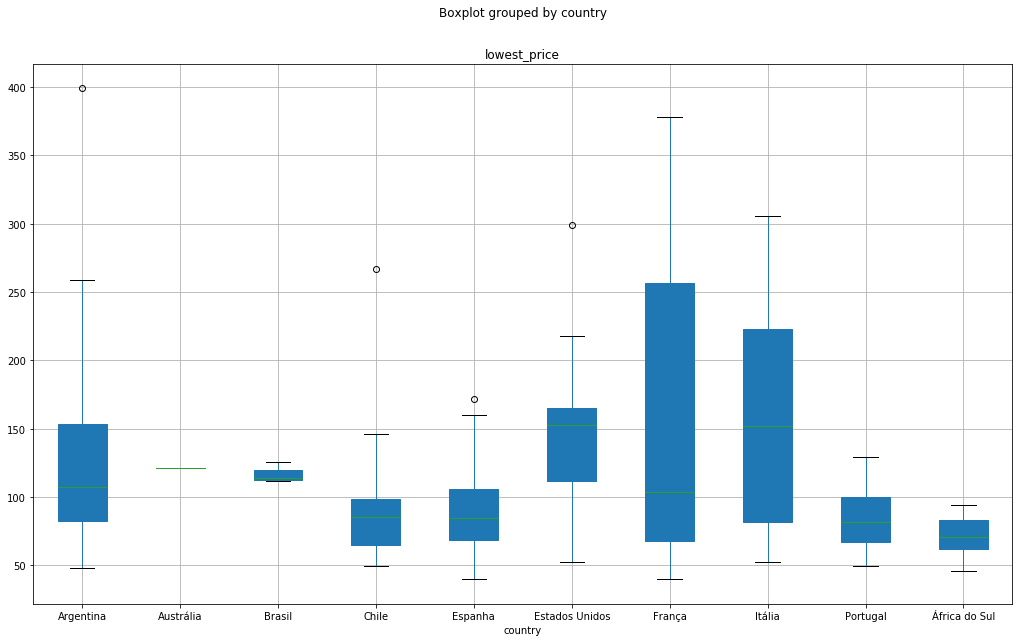

In [66]:
### Referencia: wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 200.0) & (wine_df.rating_count > 34.0)].boxplot(by='country',column=['lowest_price'], figsize=(15,10), patch_artist=True)

plot_df = work_df.loc[(work_df.lowest_price <= 400.0) & (work_df.vivino_rating >= work_df.vivino_rating.median())]
plot_df.boxplot(by='country',column=['lowest_price'], figsize=(17,10), patch_artist=True)

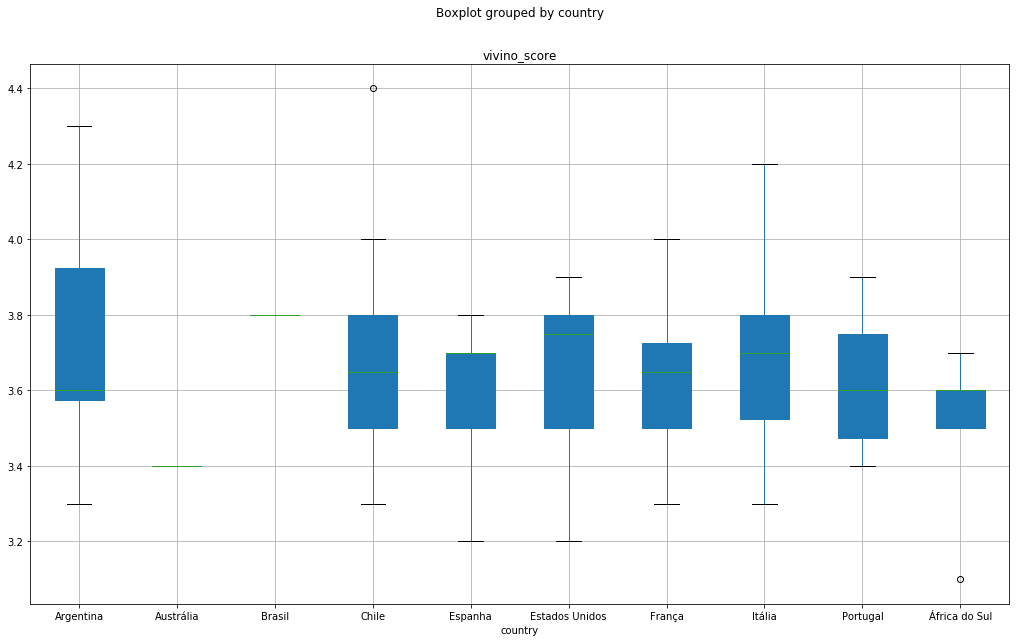

In [67]:
plot_df.boxplot(by='country',column=['vivino_score'], figsize=(17,10), patch_artist=True)

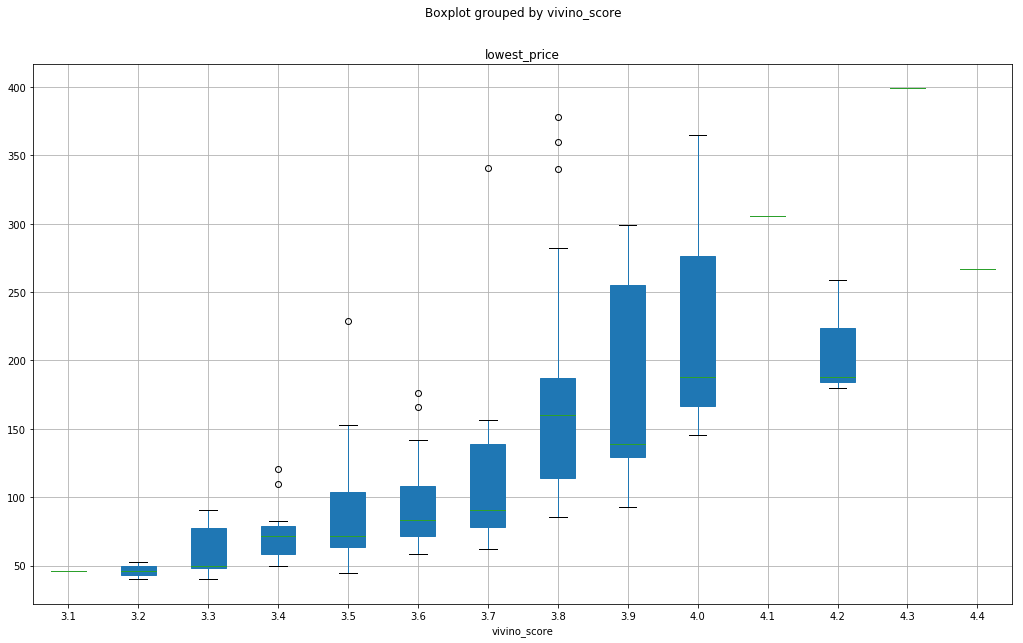

In [68]:
plot_df.boxplot(by='vivino_score',column=['lowest_price'], figsize=(17,10), patch_artist=True)

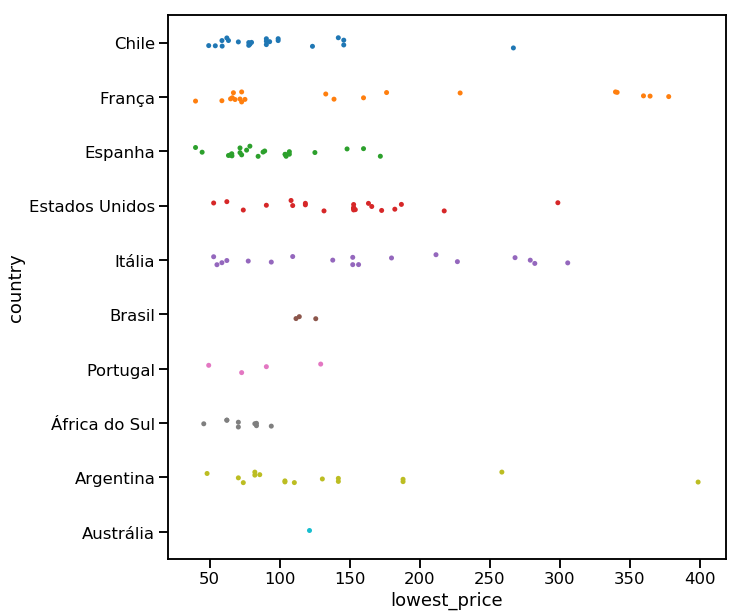

In [99]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.stripplot(x="lowest_price", y="country", data=plot_df, ax=ax, jitter= True)
plt.show()

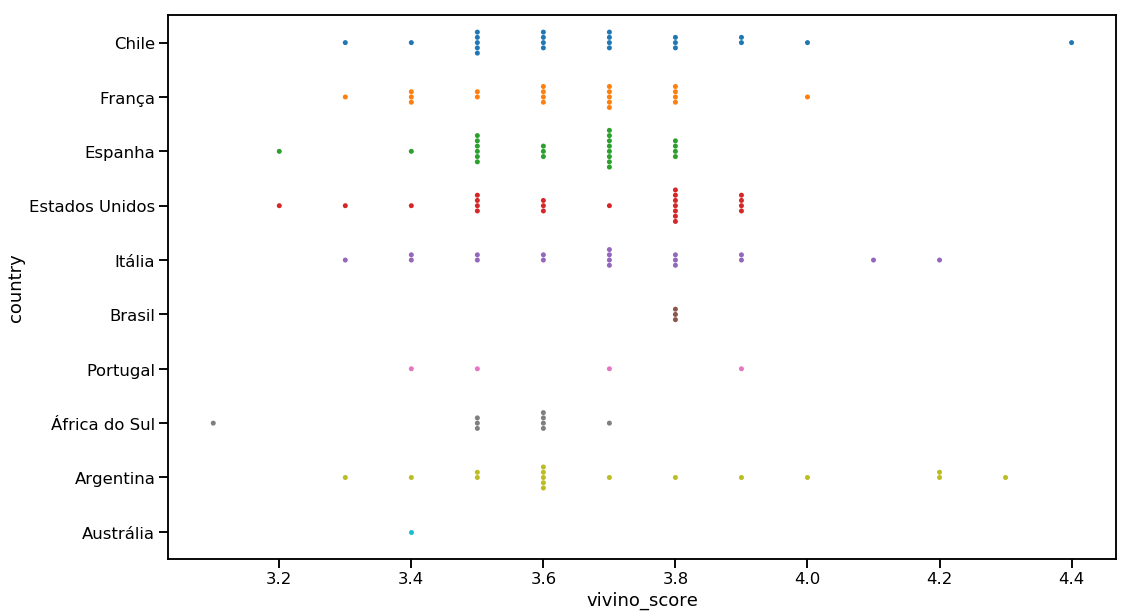

In [98]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="country", data=plot_df, ax=ax)
plt.show()

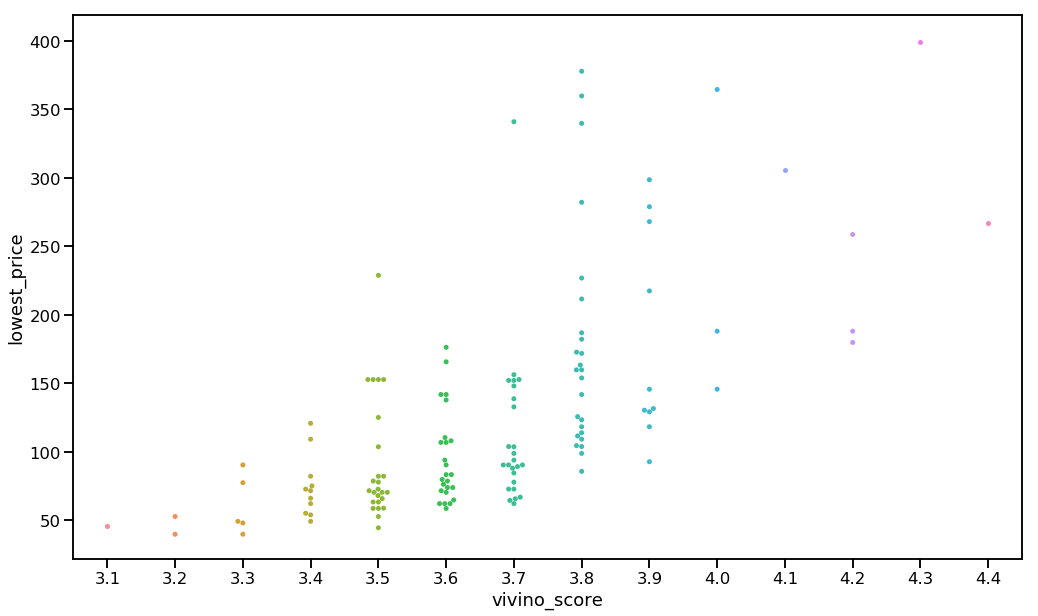

In [101]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="lowest_price", data=plot_df, ax=ax)
plt.show()

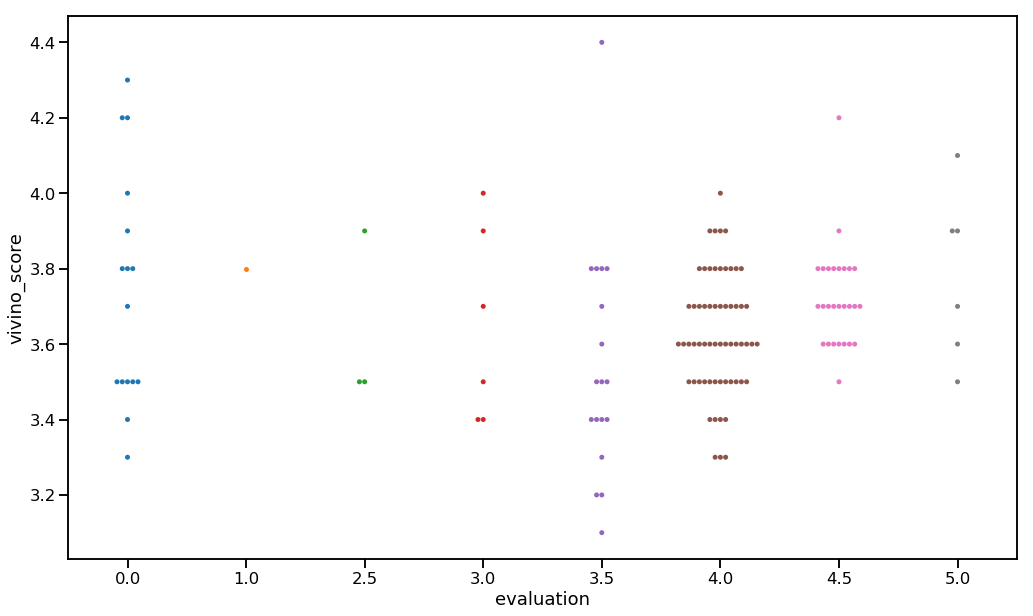

In [103]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="evaluation", y="vivino_score", data=plot_df, ax=ax)
plt.show()

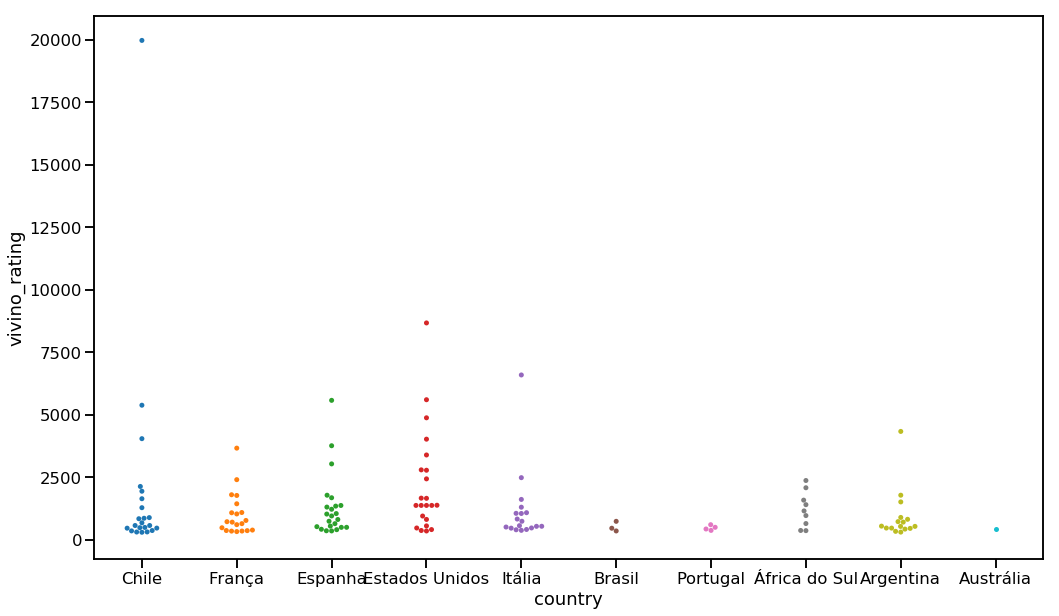

In [104]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="country", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

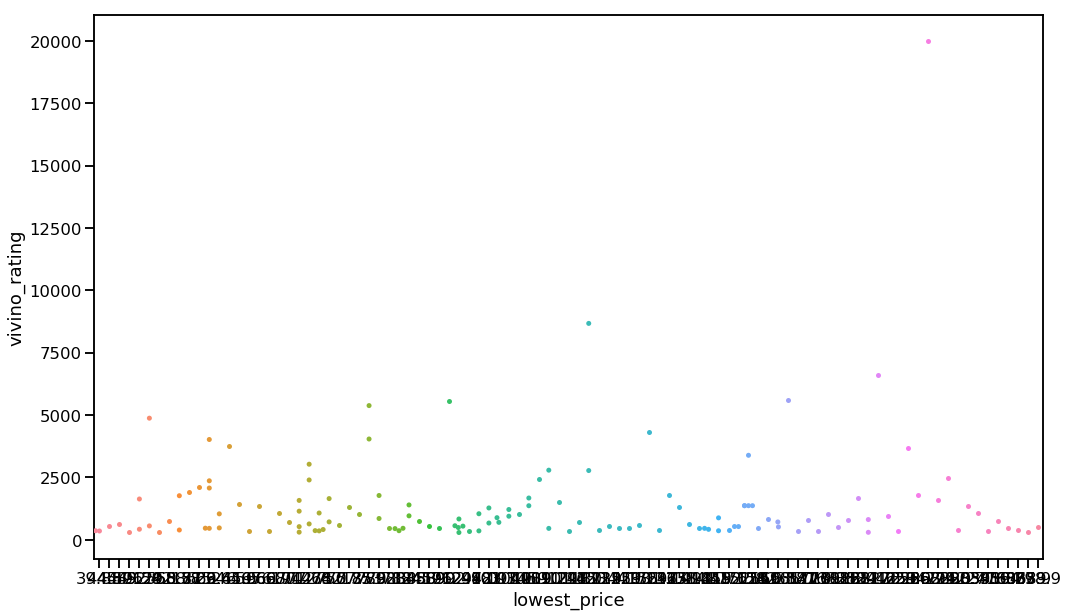

In [105]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="lowest_price", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

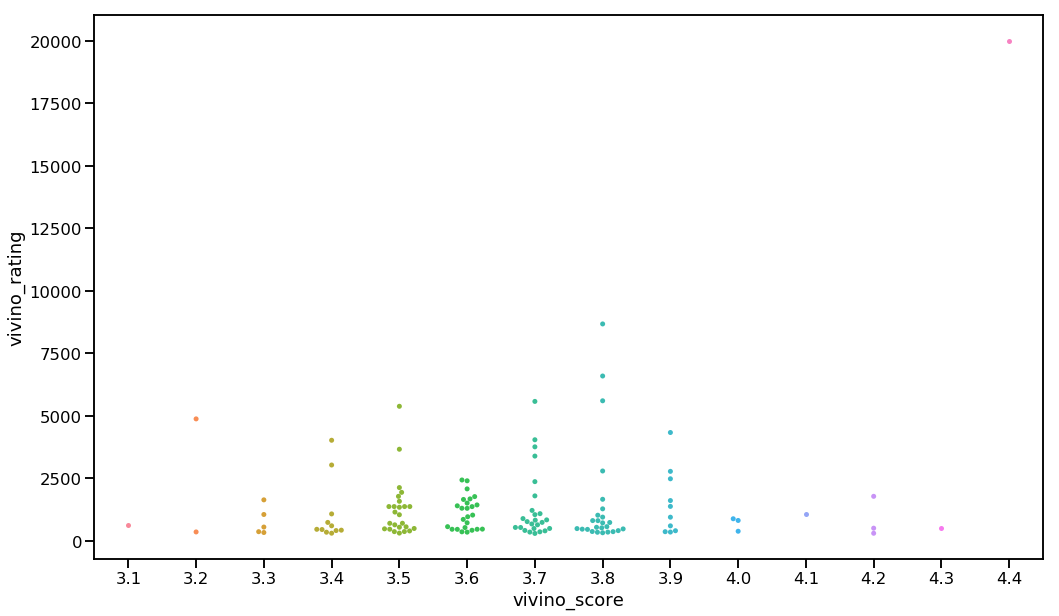

In [106]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

In [114]:
menor_preco = work_df.groupby(['country','vivino_score']).apply(lambda df: df.loc[df.lowest_price.idxmin()])
display(menor_preco)

Unnamed: 0  \
country       vivino_score               
Alemanha      3.6                  328   
Argentina     3.3                  298   
              3.4                  142   
              3.5                  157   
              3.6                  228   
              3.7                  284   
              3.8                  199   
              3.9                  333   
              4.0                   98   
              4.2                  287   
              4.3                  308   
Austrália     3.2                  278   
              3.4                  194   
Brasil        3.4                   64   
              3.5                  130   
              3.6                  192   
              3.7                   62   
              3.8                  189   
              4.2                   25   
Chile         3.3                  190   
              3.4                  220   
              3.5                  322   
              3.6                  216   
              3.7                  257   
              3.8                  263   
              3.9                  177   
              4.0                  283   
              4.1                  270   
              4.2                  169   
              4.4                   87   
...                                ...   
Itália        3.7                   49   
              3.8                  366   
              3.9                   20   
              4.1                   43   
              4.2                  180   
              4.3                  121   
Líbano        3.8                   91   
Portugal      3.2                  223   
              3.3                  267   
              3.4                  338   
              3.5                  174   
              3.7                  224   
              3.9                  115   
              4.0                  202   
              4.1                   79   
              4.2                  299   
              4.3                  102   
Uruguai       3.0                  305   
              3.1                  342   
              3.2                  187   
              3.3                   47   
              3.6                  339   
              4.3                  128   
África do Sul 3.1                  161   
              3.4                  154   
              3.5                  264   
              3.6                  340   
              3.7                  329   
              4.1                  109   
              4.2                  104   

                                                                    wine_name  \
country       vivino_score                                                      
Alemanha      3.6           Ernst Loosen Winemakers Select Pfalz Edition P...   
Argentina     3.3                                 Mixtus Cabernet Merlot 2018   
              3.4                                    Mixtus Syrah Malbec 2018   
              3.5                          Pasos Del Tango Merlot Malbec 2019   
              3.6                       Altivo Vineyard Selection Malbec 2018   
              3.7           Finca Trapezio Grand Barrel Selection Malbec 2017   
              3.8           Partridge Gran Reserva Mendoza Cabernet Sauvig...   
              3.9                    Clos de Los Siete By Michel Rolland 2016   
              4.0                    Terrazas de Los Andes Reserva Syrah 2017   
              4.2                                     Luigi Bosca Malbec 2018   
              4.3               Luigi Bosca Terroir Los Miradores Malbec 2017   
Austrália     3.2                         Oxford Landing Cabernet Shiraz 2016   
              3.4                                  Oxford Landing Shiraz 2017   
Brasil        3.4                         Casa Perini Cabernet Sauvignon 2018   
              3.5           Casa Perini Solidário Cabernet Sauvignon Merlo...   
    